In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(1234)

In [22]:
# figures
import matplotlib.mlab as ml
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.ticker as plticker
import palettable
import seaborn as sns
import numpy as np
import pandas as pd 

def stdfigsize(scale=1, nx=1, ny=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.
    -------
    returns (7*ratio*scale*nx, 7.*scale*ny)
    By default: ratio=1.3
    If ratio<0 them ratio = golden ratio
    """
    if ratio < 0:
        ratio = 1.61803398875
    return((7*ratio*scale*nx, 7*scale*ny))

def stdrcparams(usetex=True):
    """
    Set several mpl.rcParams and sns.set_style for my taste.
    ----
    usetex = True
    ----
    """
    sns.set_style("white")
    sns.set_style({"xtick.direction": "out",
                 "ytick.direction": "out"})
    rcparams = {
    'text.usetex': usetex,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Times'],
    'axes.labelsize': 35,
    'axes.titlesize': 35,
    'legend.fontsize': 20,
    'ytick.right': 'off',
    'xtick.top': 'off',
    'ytick.left': 'on',
    'xtick.bottom': 'on',
    'xtick.labelsize': '25',
    'ytick.labelsize': '25',
    'axes.linewidth': 2.5,
    'xtick.major.width': 1.8,
    'xtick.minor.width': 1.8,
    'xtick.major.size': 14,
    'xtick.minor.size': 7,
    'xtick.major.pad': 10,
    'xtick.minor.pad': 10,
    'ytick.major.width': 1.8,
    'ytick.minor.width': 1.8,
    'ytick.major.size': 14,
    'ytick.minor.size': 7,
    'ytick.major.pad': 10,
    'ytick.minor.pad': 10,
    'axes.labelpad': 15,
    'axes.titlepad': 15,
    'axes.spines.right': False,
    'axes.spines.top': False}

    mpl.rcParams.update(rcparams) 
    mpl.rcParams['lines.linewidth'] = 5
    mpl.rcParams['pdf.fonttype'] = 42 

stdrcparams(usetex=True)
figsize=stdfigsize(ratio=-1)
xs,ys=figsize

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    Parameters
    ----------
    color: the color variable (e.g. 'g', '#F034A3', (.3,.55,.1)).
    amount: the lighten amount factor (Default: 0.5)
    ----------
    returns modified color
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return mpl.colors.to_hex(colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2]))
         
def plot_pacf(x, lag, axis, param_name, title=None):
    # acf  = stattools.acf(x, nlags=lag, fft=True)
    pacf = stattools.pacf(x, nlags=lag)

    axis.bar(range(len(pacf)), pacf, color = '#373aa1', alpha=0.5, label=param_name)
    axis.axhline(1/((len(x)**0.5)), linestyle='--', lw=1, color='#b32e2e')
    axis.axhline(0, color='k', lw=0.5)
    axis.axhline(-1/((len(x)**0.5)), linestyle='--', lw=1, color='#b32e2e')
    axis.set_xlabel('Lags')
    axis.set_ylabel('pacf')
    axis.legend(loc="center")
    
    if title is not None:
        axis.set_title(title)


# Simulating data

In [3]:
"""
y(t)  = Z(t)a(t) + eps(t),  eps(t)~N(0,H)
a(t+1)= T(t)a(t) + eta(t),  eta(t)~N(0,Q)
"""

nobs=200
p=2

x0 = np.ones(nobs)
x1 = np.random.normal(size=nobs)
x2 = np.random.normal(size=nobs)

k=3
m = p*k

Z = np.zeros((p, m, nobs))

for t in range(nobs):
    for i in range(p):
        Z[i,k*i:k*(i+1),t] = np.hstack([x0[t], x1[t], x2[t]])

In [4]:
pd.DataFrame(Z[:,:,0]) # visualize the Z_0

,0,1,2,3,4,5
0,1.0,0.471435,-0.319561,0.0,0.000000,0.000000
1,0.0,0.000000,0.000000,1.0,0.471435,-0.319561


In [5]:
# simulate alphas and betas
alpha1 = np.cumsum(np.random.normal(size=nobs))
alpha2 = np.cumsum(np.random.normal(size=nobs))
alpha3 = np.cumsum(np.random.normal(size=nobs))

beta11 = np.cumsum(np.random.normal(size=nobs))
beta21 = np.cumsum(np.random.normal(size=nobs))

beta12 = np.cumsum(np.random.normal(size=nobs))
beta22 = np.cumsum(np.random.normal(size=nobs))


In [6]:
# concatenate alphas and betas 
alpha = np.zeros((k*p,nobs))

for t in range(nobs):
    alpha[:,t] = np.hstack([alpha1[t], 
                           beta11[t], beta21[t],
                           alpha2[t],
                           beta12[t], beta22[t]])


In [7]:
H = 0.5*np.eye(p) # assume that the variance of error in measure equation is 0.5 for every i and t

In [8]:
# simulating y according to measure equation
y = np.zeros((p, nobs))
for t in range(nobs):
    y[:,t] = Z[:,:,t]@alpha[:,t] +  np.random.multivariate_normal(mean=np.zeros(p), cov=H, size=1)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


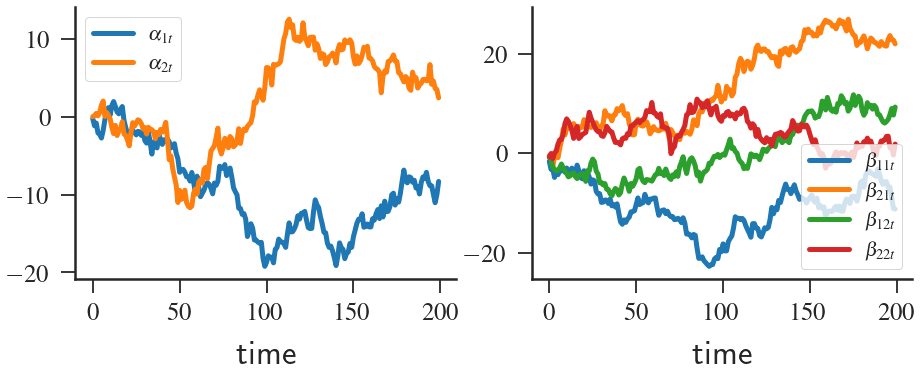

In [9]:
# plot the state (alphas and betas)
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].plot(alpha1, label="$\\alpha_{1t}$")
ax[0].plot(alpha2, label="$\\alpha_{2t}$")
ax[0].set_xlabel("time")
ax[0].legend()

ax[1].plot(beta11, label="$\\beta_{11t}$")
ax[1].plot(beta21, label="$\\beta_{21t}$")
ax[1].plot(beta12, label="$\\beta_{12t}$")
ax[1].plot(beta22, label="$\\beta_{22t}$")
ax[1].set_xlabel("time")
ax[1].legend()


# Estimation

In [10]:
from numpy.linalg import inv
from numpy.linalg import det
from numpy.linalg import solve

def kalman(y, T, Q, Z, H):
    global states
    nobs = y.shape[0]; nvar = y.shape[1]; nstates = T.shape[0]
    # 1. Initialize the filter
    a00 = np.zeros((nstates, 1))
    P00 = (10**2)*np.eye(nstates)#np.linalg.solve(np.eye(nstates**2) - np.kron(T, T), 
          #                Q.reshape((nstates*nstates, 1))).reshape((nstates,nstates))
    states = np.zeros((nstates, nobs))
    # 2. Recursion 
    loglike = 0.0
    for t in range(nobs):
        # propagation steps
        a10 = T@a00
        P10 = T@P00@T.T + Q
        # prediction step
        yhat = Z[:,:,t] @ a10
        Vhat = Z[:,:,t] @ P10 @ Z[:,:,t].T + H
        yt = y[t,:].reshape(nvar,1)
        uhat = yt - yhat
        loglike += -0.5*(nvar * np.log(2*np.pi) + np.log(det(Vhat)) + (uhat.T@inv(Vhat)@uhat))
        # correction step
        K = P10 @ Z[:,:,t].T @ inv(Vhat)
        a00 = a10 + (K @ uhat).reshape((nstates, 1))
        P00 = P10 - K @ Z[:,:,t] @ P10
        
        states[:,t] = np.squeeze(a00)
    return float(loglike)


In [11]:
# implementação mais eficiente do kalman filter
from numpy.linalg import inv
from numpy.linalg import det
from numpy.linalg import solve
from numba import njit

@njit
def kalman(y, T, Q, Z, H):
    
#     global states
    nobs, nvar = y.shape; nstates = T.shape[0]
    states = np.zeros((nstates, nobs))
    # 1. Initialize the filter
    xtm1tm1 = np.zeros((nstates, 1))
    Ptm1tm1 = (10**2)*np.eye(nstates)
    #solve(np.eye(nstates**2)-np.kron(T, T),Q.reshape((nstates**2,1))).reshape((nstates,nstates))
    # 2. Hecursion 
    loglike = 0.0
    for t in range(nobs):
        # Propagation step
        xttm1 = T@xtm1tm1
        Pttm1 = T@Ptm1tm1@T.T + Q
        # Prediction step
        xttim1 = xttm1
        Pttim1 = Pttm1
        for i in range(nvar):
            yhat = Z[i:i+1,:,t]@xttim1
            uhat = y[t,i:i+1] - yhat
            Vhat = Z[i:i+1,:,t]@Pttim1@Z[i:i+1,:,t].T + H[i,i]
            if Vhat[0,0]>0:
                loglike += -0.5*(np.log(2*np.pi) + np.log(Vhat[0,0]) + (uhat[0,0]**2)/Vhat[0,0])
#                 print(loglike)
            # correction step
            K = Pttim1@Z[i:i+1,:,t].T*(1/Vhat)
            xttim1 = xttim1 + K*uhat
            Pttim1 = Pttim1 - K@Z[i:i+1,:,t]@Pttim1
        xtm1tm1 = xttim1
        Ptm1tm1 = Pttim1

        states[:,t] =xtm1tm1.T


    return loglike, states

##  run the kalman filter for a set of parameters


In [12]:
def state_space_matrices(params, y, Z):
    p, nobs = y.shape
    k_times_p = Z.shape[1]
#     k = int(k_times_p/p)
    
    T = np.eye(k_times_p)
    H = np.diag(params[:p])**2
    Q = np.diag(params[p:])**2
    
    return y, T, Q, Z, H

In [13]:
params0  = np.array([1, 1, 0.5, 0.5, 0.5, 0.5,0.5,0.5])**0.5 # true parameters
yy, TT, QQ, ZZ, HH=state_space_matrices(params0, y, Z)

In [16]:
loglike, states =kalman(yy.T, TT, QQ, ZZ, HH)

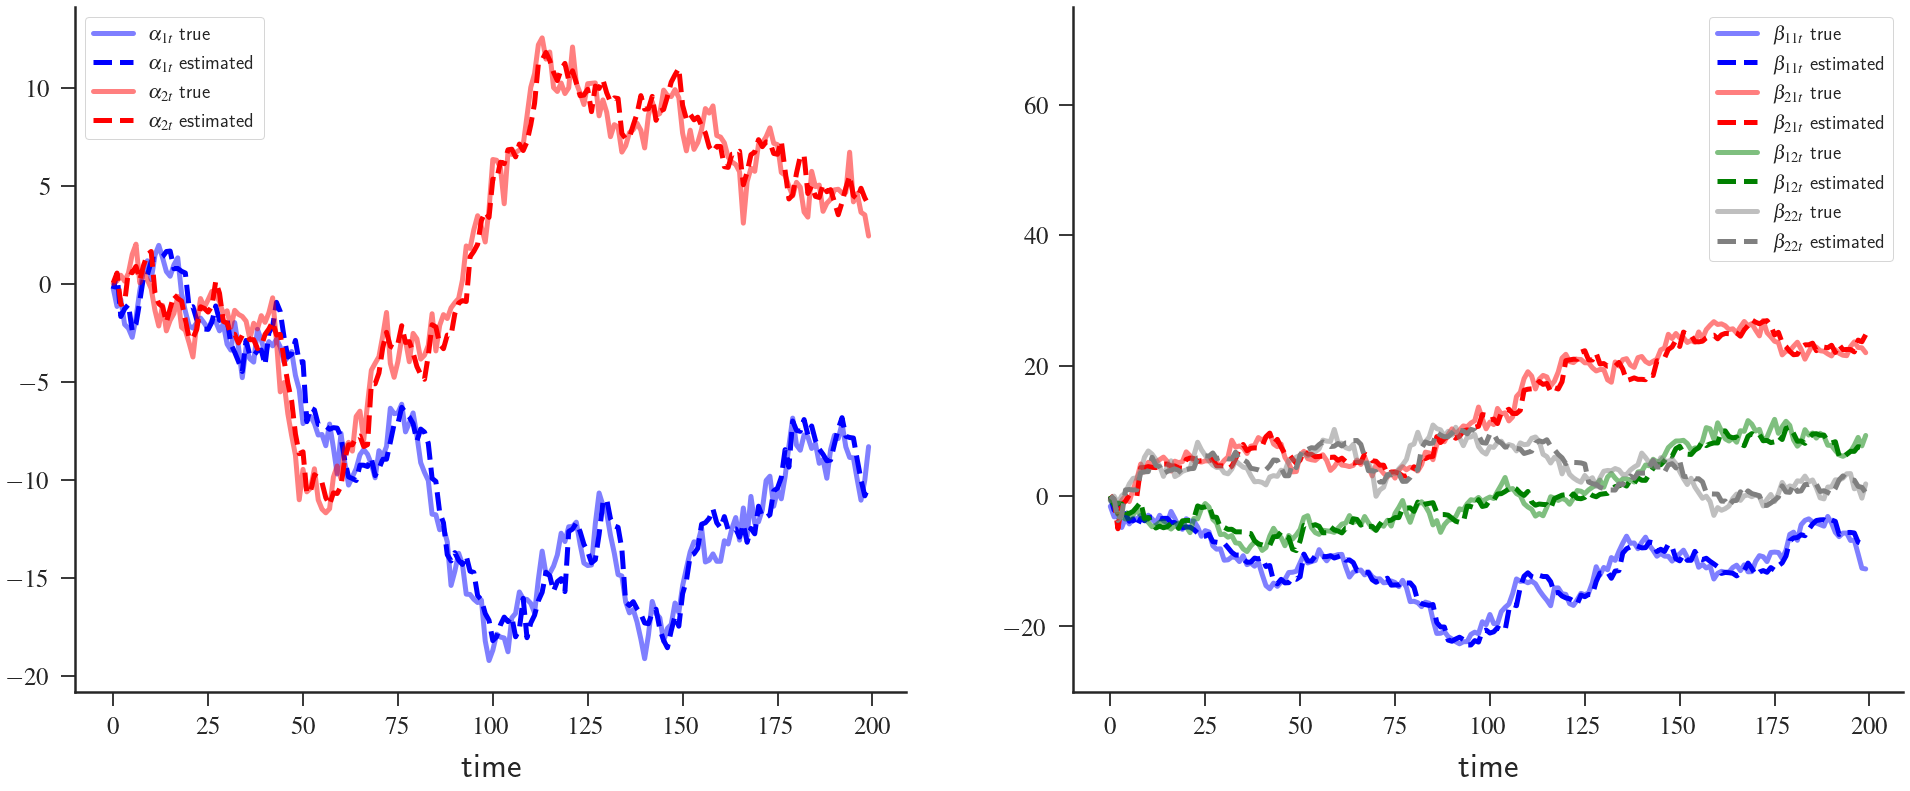

In [18]:
# plot alphas and betas true and estimated with kalman filter
fig, ax = plt.subplots(ncols=2, figsize=stdfigsize(nx=2,ny=1, scale=1.8))
ax[0].plot(alpha1, color='b', alpha=0.5, label="$\\alpha_{1t}$ true")
ax[0].plot(states[0,:], '--', color='b', label="$\\alpha_{1t}$ estimated")

ax[0].plot(alpha2, color='r', alpha=0.5,  label="$\\alpha_{2t}$ true")
ax[0].plot(states[3,:], '--',color='r',label="$\\alpha_{2t}$ estimated")

ax[0].set_xlabel("time")
ax[0].legend()

ax[1].plot(beta11, color='b', alpha=0.5,  label="$\\beta_{11t}$ true")
ax[1].plot(states[1,:], '--', color='b', label="$\\beta_{11t}$ estimated")

ax[1].plot(beta21, color='r', alpha=0.5,  label="$\\beta_{21t}$ true")
ax[1].plot(states[2,:], '--', color='r', label="$\\beta_{21t}$ estimated")

ax[1].plot(beta12, color='green', alpha=0.5,  label="$\\beta_{12t}$ true")
ax[1].plot(states[4,:], '--', color='green', label="$\\beta_{12t}$ estimated")

ax[1].plot(beta22, color='gray', alpha=0.5,  label="$\\beta_{22t}$ true")
ax[1].plot(states[5,:], '--', color='gray', label="$\\beta_{22t}$ estimated")

ax[1].set_xlabel("time")
ax[1].set_ylim(-30, 75)
ax[1].legend()
plt.show()

## Log-likelihood

In [19]:
def loglike(params):
    yy, TT, QQ, ZZ, HH=state_space_matrices(params, y, Z)  
    ll, states = kalman(yy.T, TT, QQ, ZZ, HH)    
    return ll

from scipy import optimize
params0 = np.array([1. , 1. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])**0.5
max_like = optimize.minimize(lambda param: -loglike(param), x0=params0,  method='Nelder-Mead')
param_ml = max_like.x
param_ml

array([0.45147135, 0.8686988 , 0.98799954, 1.06649122, 1.01192604,
       0.98615072, 0.71558676, 0.82627862])

In [20]:
loglike(params0)

-954.2533937652357

In [21]:
from scipy import optimize
params0 = np.array([1. , 1. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])**0.5
max_like = optimize.minimize(lambda param: -loglike(param), x0=params0,  method='Nelder-Mead')
param_ml = max_like.x
param_ml

array([0.45147135, 0.8686988 , 0.98799954, 1.06649122, 1.01192604,
       0.98615072, 0.71558676, 0.82627862])

## priors

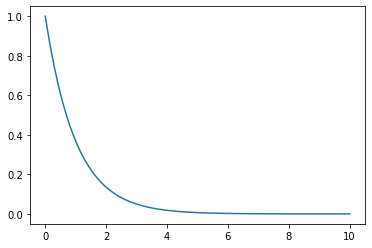

In [18]:
from scipy.stats import norm, gamma

xs = np.linspace(0, 10, 100)
plt.plot(xs, gamma.pdf(xs, a=1, loc=0, scale=1))

In [19]:

def logprior(params):
    lprior = 0
    for i in range(len(params)):
         lprior += gamma.logpdf(params[i], a=1, loc=0, scale=1)
    return lprior
def logposteriror(params):
    return loglike(params) + logprior(params)

In [20]:
def logposteriror(params):
    return loglike(params) + logprior(params)

In [21]:

def metropolis(param0, niter, logpost, accept_target=0.5, cov=None):
    
    """ Description: Run a random walk metropolis-hasting for a given log posterior
    param(i) ~ N[param(i-1), scale * cov]
    
    Inputs:
    --------
    param0:        (array)    Initial parameters of metropolis
    niter:         (int)      Number of iterations
    logpost:       (function) 
    accept_target: (float)    Target acceptance rate
    """
    global acceptance_rate
    if cov is None:
        cov = np.eye(len(param0))

    scale = 2.38/pow(len(param0), 0.5) # a rule-of-thumb initial scale
    
    accept = 0.001
    samples = np.zeros((1+niter, len(param0)))
    samples[0,:] = param0

    progress_bar = tqdm(range(1,niter+1))
    for i in progress_bar:
        proposal = np.random.multivariate_normal(samples[i-1,:], scale*cov) # sample a proposal
        if (np.log(np.random.uniform(0,1)) < (logpost(proposal)-logpost(samples[i-1,:]))): # metropolis-step
            samples[i,:] = proposal
            accept += 1
        else:
            samples[i,:] = samples[i-1,:]
        acceptance_rate=accept/i
        # update the scale parameter to achieve the target acceptance rate
        if i%100==0 and i<niter*0.5:
            New_scale = scale*(norm.ppf(accept_target/2)/norm.ppf(acceptance_rate/2))
            if New_scale>0:
                scale=New_scale
            else:
                scale=0.001
        progress_bar.set_postfix({'acceptance rate': acceptance_rate})
    return samples[1:]


In [38]:
params0


array([1.        , 1.        , 0.70710678, 0.70710678, 0.70710678,
       0.70710678, 0.70710678, 0.70710678])

In [39]:
samples = metropolis(params0, niter=20000, logpost=logposteriror, accept_target=0.25, cov=None)

100%|██████████| 20000/20000 [09:23<00:00, 35.49it/s, acceptance rate=0.313]


In [47]:
summary = pd.concat([pd.DataFrame(samples).describe().T['mean'], pd.DataFrame(param_ml)], axis=1)
summary.columns=['bayesian (mean)', 'MLE']
summary.round(4)

,bayesian (mean),MLE
0,0.6219,0.6291
1,0.7514,0.7545
2,1.0930,1.0897
3,1.0798,1.0835
4,0.9927,0.9936
5,0.9873,0.9815
6,1.0006,1.0027
7,1.0276,1.0309


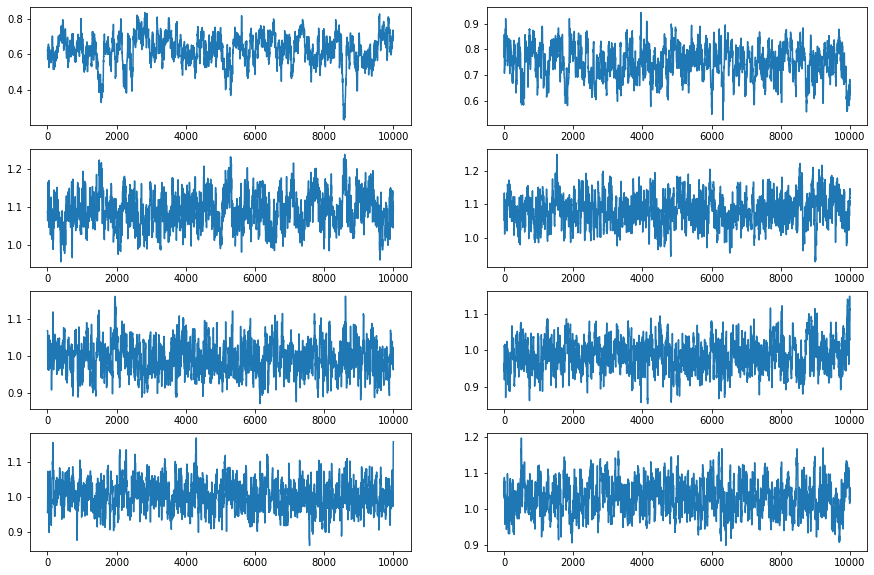

In [42]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15,10))

k=0
for i in range(4):
    for j in range(2):
        ax[i,j].plot(samples[10000:,k])
        k+=1

# Dados

In [150]:
data = pd.read_csv("../Downloads/log_df.csv"). drop(["Unnamed: 0"], axis=1)


(16845, 13)

In [344]:
msas=[]
for msa in np.unique(data['MSA']):
    count=0
    df=data[data.MSA==msa]
    for year in range(1960,2015):
        if len(df[df.Year==year])==1:
            count=count+1
    if count==55:
        msas.append(msa)
df=data[data.MSA.isin(msas)]

In [345]:
all_data= df

In [552]:
regions = set(all_data['Regions'].values)
regions

{'Midwest', 'Northeast', 'South', 'West'}

In [347]:
data1 = all_data[all_data['Regions']=='Midwest']
data2 = all_data[all_data['Regions']=='Northeast']    
data3 = all_data[all_data['Regions']=='South']
data4 = all_data[all_data['Regions']=='West']
data1.head()

,MSA,State,Year,Whites,Blacks,Minorities,Poverty,Unemployment,Education,Burglary,Murder,Population,Regions
49,"Akron, OH",OH,1960.0,5.749100,4.666799,2.896526,4.857803,3.303844,4.983888,3.441381,1.079181,5.782017,Midwest
50,"Akron, OH",OH,1961.0,5.757072,4.674540,2.851258,4.841797,3.401056,4.980381,2.955207,0.602060,5.790249,Midwest
51,"Akron, OH",OH,1962.0,5.764297,4.682091,2.803457,4.827098,3.494155,4.975763,3.492481,1.278754,5.797774,Midwest
52,"Akron, OH",OH,1963.0,5.770770,4.689424,2.753583,4.813694,3.582518,4.970035,3.517724,1.204120,5.804590,Midwest
53,"Akron, OH",OH,1964.0,5.776485,4.696549,2.705008,4.801609,3.666612,4.963193,3.435526,1.113943,5.810691,Midwest


In [348]:
y1 = np.zeros((len(np.unique(data1["MSA"])), 55))
x01 = np.zeros((len(np.unique(data1["MSA"])), 55))
x11 = np.zeros((len(np.unique(data1["MSA"])), 55))
x21 = np.zeros((len(np.unique(data1["MSA"])), 55))
x31 = np.zeros((len(np.unique(data1["MSA"])), 55))
x41 = np.zeros((len(np.unique(data1["MSA"])), 55))
x51 = np.zeros((len(np.unique(data1["MSA"])), 55))
x61 = np.zeros((len(np.unique(data1["MSA"])), 55))


i=0
for msa in np.unique(data1["MSA"]):
    y1[i,:] = data1[data1["MSA"]==msa]['Murder'].values
    x01[i,:] = np.ones(55)
    x11[i,:] = data1[data1["MSA"]==msa]['Whites'].values
    x21[i,:] = data1[data1["MSA"]==msa]['Blacks'].values
    x31[i,:] = data1[data1["MSA"]==msa]['Minorities'].values
    x41[i,:] = data1[data1["MSA"]==msa]['Poverty'].values
    x51[i,:] = data1[data1["MSA"]==msa]['Unemployment'].values
    x61[i,:] = data1[data1["MSA"]==msa]['Education'].values
    
    i+=1
# pd.DataFrame(x11).head()#, index=np.unique(data1["MSA"]), columns = data1[data1["MSA"]==msa]['Year'])

In [349]:
y2 = np.zeros((len(np.unique(data2["MSA"])), 55))
x02 = np.zeros((len(np.unique(data2["MSA"])), 55))
x12 = np.zeros((len(np.unique(data2["MSA"])), 55))
x22 = np.zeros((len(np.unique(data2["MSA"])), 55))
x32 = np.zeros((len(np.unique(data2["MSA"])), 55))
x42 = np.zeros((len(np.unique(data2["MSA"])), 55))
x52 = np.zeros((len(np.unique(data2["MSA"])), 55))
x62 = np.zeros((len(np.unique(data2["MSA"])), 55))


i=0
for msa in np.unique(data2["MSA"]):
    y2[i,:] = data2[data2["MSA"]==msa]['Murder'].values
    x02[i,:] = np.ones(55)
    x12[i,:] = data2[data2["MSA"]==msa]['Whites'].values
    x22[i,:] = data2[data2["MSA"]==msa]['Blacks'].values
    x32[i,:] = data2[data2["MSA"]==msa]['Minorities'].values
    x42[i,:] = data2[data2["MSA"]==msa]['Poverty'].values
    x52[i,:] = data2[data2["MSA"]==msa]['Unemployment'].values
    x62[i,:] = data2[data2["MSA"]==msa]['Education'].values
    
    i+=1
# pd.DataFrame(x12).head()#, index=np.unique(data1["MSA"]), columns = data1[data1["MSA"]==msa]['Year'])

In [350]:
y3 = np.zeros((len(np.unique(data3["MSA"])), 55))
x03 = np.zeros((len(np.unique(data3["MSA"])), 55))
x13 = np.zeros((len(np.unique(data3["MSA"])), 55))
x23 = np.zeros((len(np.unique(data3["MSA"])), 55))
x33 = np.zeros((len(np.unique(data3["MSA"])), 55))
x43 = np.zeros((len(np.unique(data3["MSA"])), 55))
x53 = np.zeros((len(np.unique(data3["MSA"])), 55))
x63 = np.zeros((len(np.unique(data3["MSA"])), 55))


i=0
for msa in np.unique(data3["MSA"]):
    y3[i,:] = data3[data3["MSA"]==msa]['Murder'].values
    x03[i,:] = np.ones(55)
    x13[i,:] = data3[data3["MSA"]==msa]['Whites'].values
    x23[i,:] = data3[data3["MSA"]==msa]['Blacks'].values
    x33[i,:] = data3[data3["MSA"]==msa]['Minorities'].values
    x43[i,:] = data3[data3["MSA"]==msa]['Poverty'].values
    x53[i,:] = data3[data3["MSA"]==msa]['Unemployment'].values
    x63[i,:] = data3[data3["MSA"]==msa]['Education'].values
    
    i+=1
# pd.DataFrame(x13).head()#, index=np.unique(data1["MSA"]), columns = data1[data1["MSA"]==msa]['Year'])

In [351]:
y4 = np.zeros((len(np.unique(data4["MSA"])), 55))
x04 = np.zeros((len(np.unique(data4["MSA"])), 55))
x14 = np.zeros((len(np.unique(data4["MSA"])), 55))
x24 = np.zeros((len(np.unique(data4["MSA"])), 55))
x34 = np.zeros((len(np.unique(data4["MSA"])), 55))
x44 = np.zeros((len(np.unique(data4["MSA"])), 55))
x54 = np.zeros((len(np.unique(data4["MSA"])), 55))
x64 = np.zeros((len(np.unique(data4["MSA"])), 55))


i=0
for msa in np.unique(data4["MSA"]):
    y4[i,:] = data4[data4["MSA"]==msa]['Murder'].values
    x04[i,:] = np.ones(55)
    x14[i,:] = data4[data4["MSA"]==msa]['Whites'].values
    x24[i,:] = data4[data4["MSA"]==msa]['Blacks'].values
    x34[i,:] = data4[data4["MSA"]==msa]['Minorities'].values
    x44[i,:] = data4[data4["MSA"]==msa]['Poverty'].values
    x54[i,:] = data4[data4["MSA"]==msa]['Unemployment'].values
    x64[i,:] = data4[data4["MSA"]==msa]['Education'].values
    
    i+=1
# pd.DataFrame(x14).head()#, index=np.unique(data1["MSA"]), columns = data1[data1["MSA"]==msa]['Year'])

In [429]:
y = np.vstack([y1, y2, y3, y4])

In [430]:
p = sum([x11.shape[0],
        x12.shape[0],
        x13.shape[0],
        x14.shape[0]])


In [433]:
k = 7 # number of regressors plus constant

Z = np.zeros((p, k*4, nobs))


for t in range(55):
    
    i1=0
    i2=0
    i3=0
    i4=0

    
    for i in range(p):
        
        if (i < x11.shape[0]):
            j=0
            Z[i,k*j:k*(j+1),t] = np.hstack([ x01[i1,t],
                                             x11[i1,t],
                                             x21[i1,t],
                                             x31[i1,t],
                                             x41[i1,t],
                                             x51[i1,t],
                                             x61[i1,t]])
            i1+=1
            
        if i>=x11.shape[0] and i<(x11.shape[0]+x12.shape[0]):
            j=1
            Z[i,k*j:k*(j+1),t] = np.hstack([ x02[i2,t],
                                             x12[i2,t],
                                             x22[i2,t],
                                             x32[i2,t],
                                             x42[i2,t],
                                             x52[i2,t],
                                             x62[i2,t]])
            i2+=1
            
        if i>=(x11.shape[0]+x12.shape[0]) and i<(x11.shape[0]+x12.shape[0]+x13.shape[0]):
            j=2
            Z[i,k*j:k*(j+1),t] = np.hstack([ x03[i3,t],
                                             x13[i3,t],
                                             x23[i3,t],
                                             x33[i3,t],
                                             x43[i3,t],
                                             x53[i3,t],
                                             x63[i3,t]])
            i3+=1
#             print(i3)
        if i>=(x11.shape[0]+x12.shape[0]+x13.shape[0]) and i<(x11.shape[0]+x12.shape[0]+x13.shape[0]+x14.shape[0]):
            j=3
            Z[i,k*j:k*(j+1),t] =  np.hstack([x04[i4,t],
                                             x14[i4,t],
                                             x24[i4,t],
                                             x34[i4,t],
                                             x44[i4,t],
                                             x54[i4,t],
                                             x64[i4,t]])
            i4+=1

In [427]:
# pd.DataFrame(Z[:,:,0])

In [476]:
from scipy.linalg import block_diag
# param=np.array([.1,.2,.3,.4,.1,.1,.1,.1,.1,.1,.1,.2,.2,.2,.2,.2,.2,.2,.3,.3,.3,.3,.3,.3,.3,.4,.4,.4,.4,.4,.4,.4])

def ssm(param):

    H1 = (param[0]**2)*np.eye(y1.shape[0])
    H2 = (param[1]**2)*np.eye(y2.shape[0])
    H3 = (param[2]**2)*np.eye(y3.shape[0])
    H4 = (param[3]**2)*np.eye(y4.shape[0])

    H = block_diag(H1,H2,H3,H4)
    Q = np.diag(param[4:]**2)
    T = np.eye(7*4)
    return H, Q, T

In [511]:
param = np.ones(4+28)
HH, QQ, TT = ssm(param)

In [512]:
Z.shape

(136, 28, 200)

In [513]:
ll, states = kalman(y.T, TT, QQ, Z, HH)

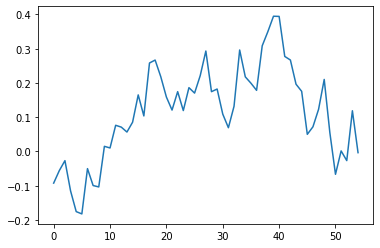

In [514]:
plt.plot(states[3,:])

In [519]:
def loglike(params):
    HH, QQ, TT=ssm(params)  
    ll, states = kalman(y.T, TT, QQ, Z, HH)    
    return ll


In [581]:
params0 = np.ones(28+4)
params0 = np.ones(28+4)
loglike(params0)

-8474.114598228633

In [582]:

from scipy import optimize
max_like = optimize.minimize(lambda param: -loglike(param), x0=params0,  method='Nelder-Mead')
param_ml = max_like.x
param_ml

array([ 0.1969815 ,  0.16250877,  0.16798498,  0.17546002,  2.01664518,
        0.85409999,  1.04328816,  0.83379607,  0.10721244,  1.50427983,
        1.35174113,  1.05836643,  0.18066846,  0.09199899,  2.29163242,
        1.66752245,  1.6009368 , -0.0677113 ,  0.40032307,  2.44240951,
        0.6295291 ,  0.85766209,  0.60152125,  0.44808409,  0.09918538,
        0.16290503,  2.20392241,  1.79851444,  0.12767593,  3.67564462,
        0.93943739,  1.34376122])

In [583]:
HH, QQ, TT = ssm(param_ml)
ll, states = kalman(y.T, TT, QQ, Z, HH)

In [584]:
reg1 = np.array([1, 8, 15, 22])
reg2 = reg1+1
reg3 = reg2+1
reg4 = reg3+1
reg5 = reg4+1
reg6 = reg5+1


In [585]:
color = ['#7570B3', '#D95F02','#1B9E77', '#E7298A']
regions

['South', 'Northeast', 'Midwest', 'West']

In [586]:
regions=["South", "Northeast", "Midwest", "West"]

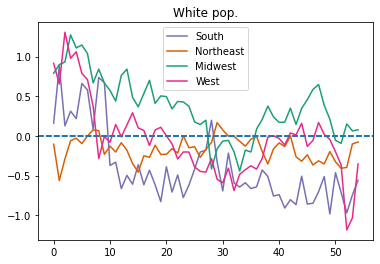

In [587]:
fig, ax = plt.subplots()

k=0
for i in reg1:
    ax.plot(states[i,:], color=color[k], label=list(regions)[k])
    ax.axhline(0, linestyle='--')
    ax.set_title('White pop.')
    
    k+=1
ax.legend()

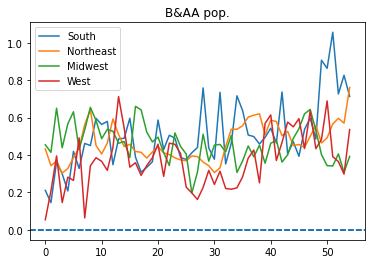

In [588]:
fig, ax = plt.subplots()

k=0
for i in reg2:
    ax.plot(states[i,:], label=list(regions)[k])
    ax.axhline(0, linestyle='--')
    ax.set_title('B&AA pop.')
    
    k+=1
ax.legend()

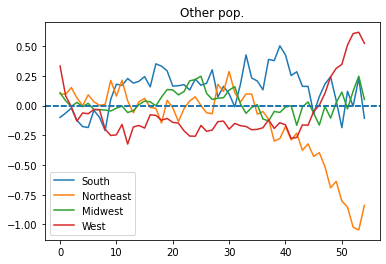

In [589]:
fig, ax = plt.subplots()
k=0
for i in reg3:
    ax.plot(states[i,:], label=list(regions)[k])
    ax.axhline(0, linestyle='--') 
    ax.set_title('Other pop.')
    
    k+=1
ax.legend()

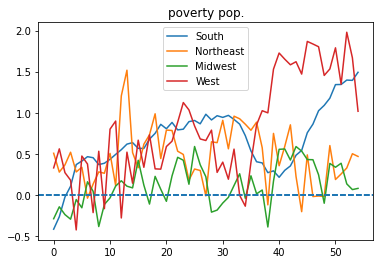

In [590]:
fig, ax = plt.subplots()
k=0
for i in reg4:
    ax.plot(states[i,:], label=list(regions)[k])
    ax.axhline(0, linestyle='--')  
    ax.set_title('poverty pop.')
    
    k+=1
ax.legend()

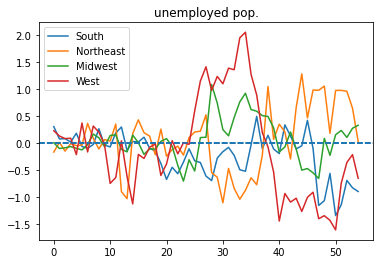

In [591]:
fig, ax = plt.subplots()
k=0

for i in reg5:
    ax.plot(states[i,:], label=list(regions)[k])
    ax.axhline(0, linestyle='--')
    ax.set_title('unemployed pop.')
    
    k+=1
ax.legend()

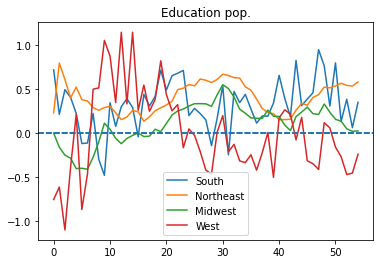

In [592]:
fig, ax = plt.subplots()
k=0
for i in reg6:
    ax.plot(states[i,:], label=list(regions)[k])
    ax.axhline(0, linestyle='--')   
    ax.set_title('Education pop.')
    
    k+=1
ax.legend()

# bayesian 

In [593]:

def logprior(params):
    lprior = 0
    for i in range(len(params)):
         lprior += gamma.logpdf(params[i], a=1, loc=0, scale=1)
    return lprior
def logposteriror(params):
    return loglike(params) + logprior(params)

In [623]:
samples = metropolis(params0/10, niter=40000, logpost=logposteriror, accept_target=0.25, cov=None)

100%|██████████| 40000/40000 [1:26:32<00:00,  7.70it/s, acceptance rate=0.28] 


In [625]:
samples.mean(axis=0)
# plt.bar(samples.mean(axis=0))

array([0.1940915 , 0.16343201, 0.17198108, 0.18390391, 0.0421178 ,
       0.00818625, 0.01000485, 0.03090675, 0.01211172, 0.01621003,
       0.01762587, 0.04828567, 0.0059926 , 0.00730743, 0.01545472,
       0.00660697, 0.00771301, 0.00545488, 0.03977388, 0.00479336,
       0.00418612, 0.01123854, 0.00512762, 0.00579324, 0.00624095,
       0.03576894, 0.01979449, 0.01145971, 0.01347599, 0.01911635,
       0.0197959 , 0.03133849])

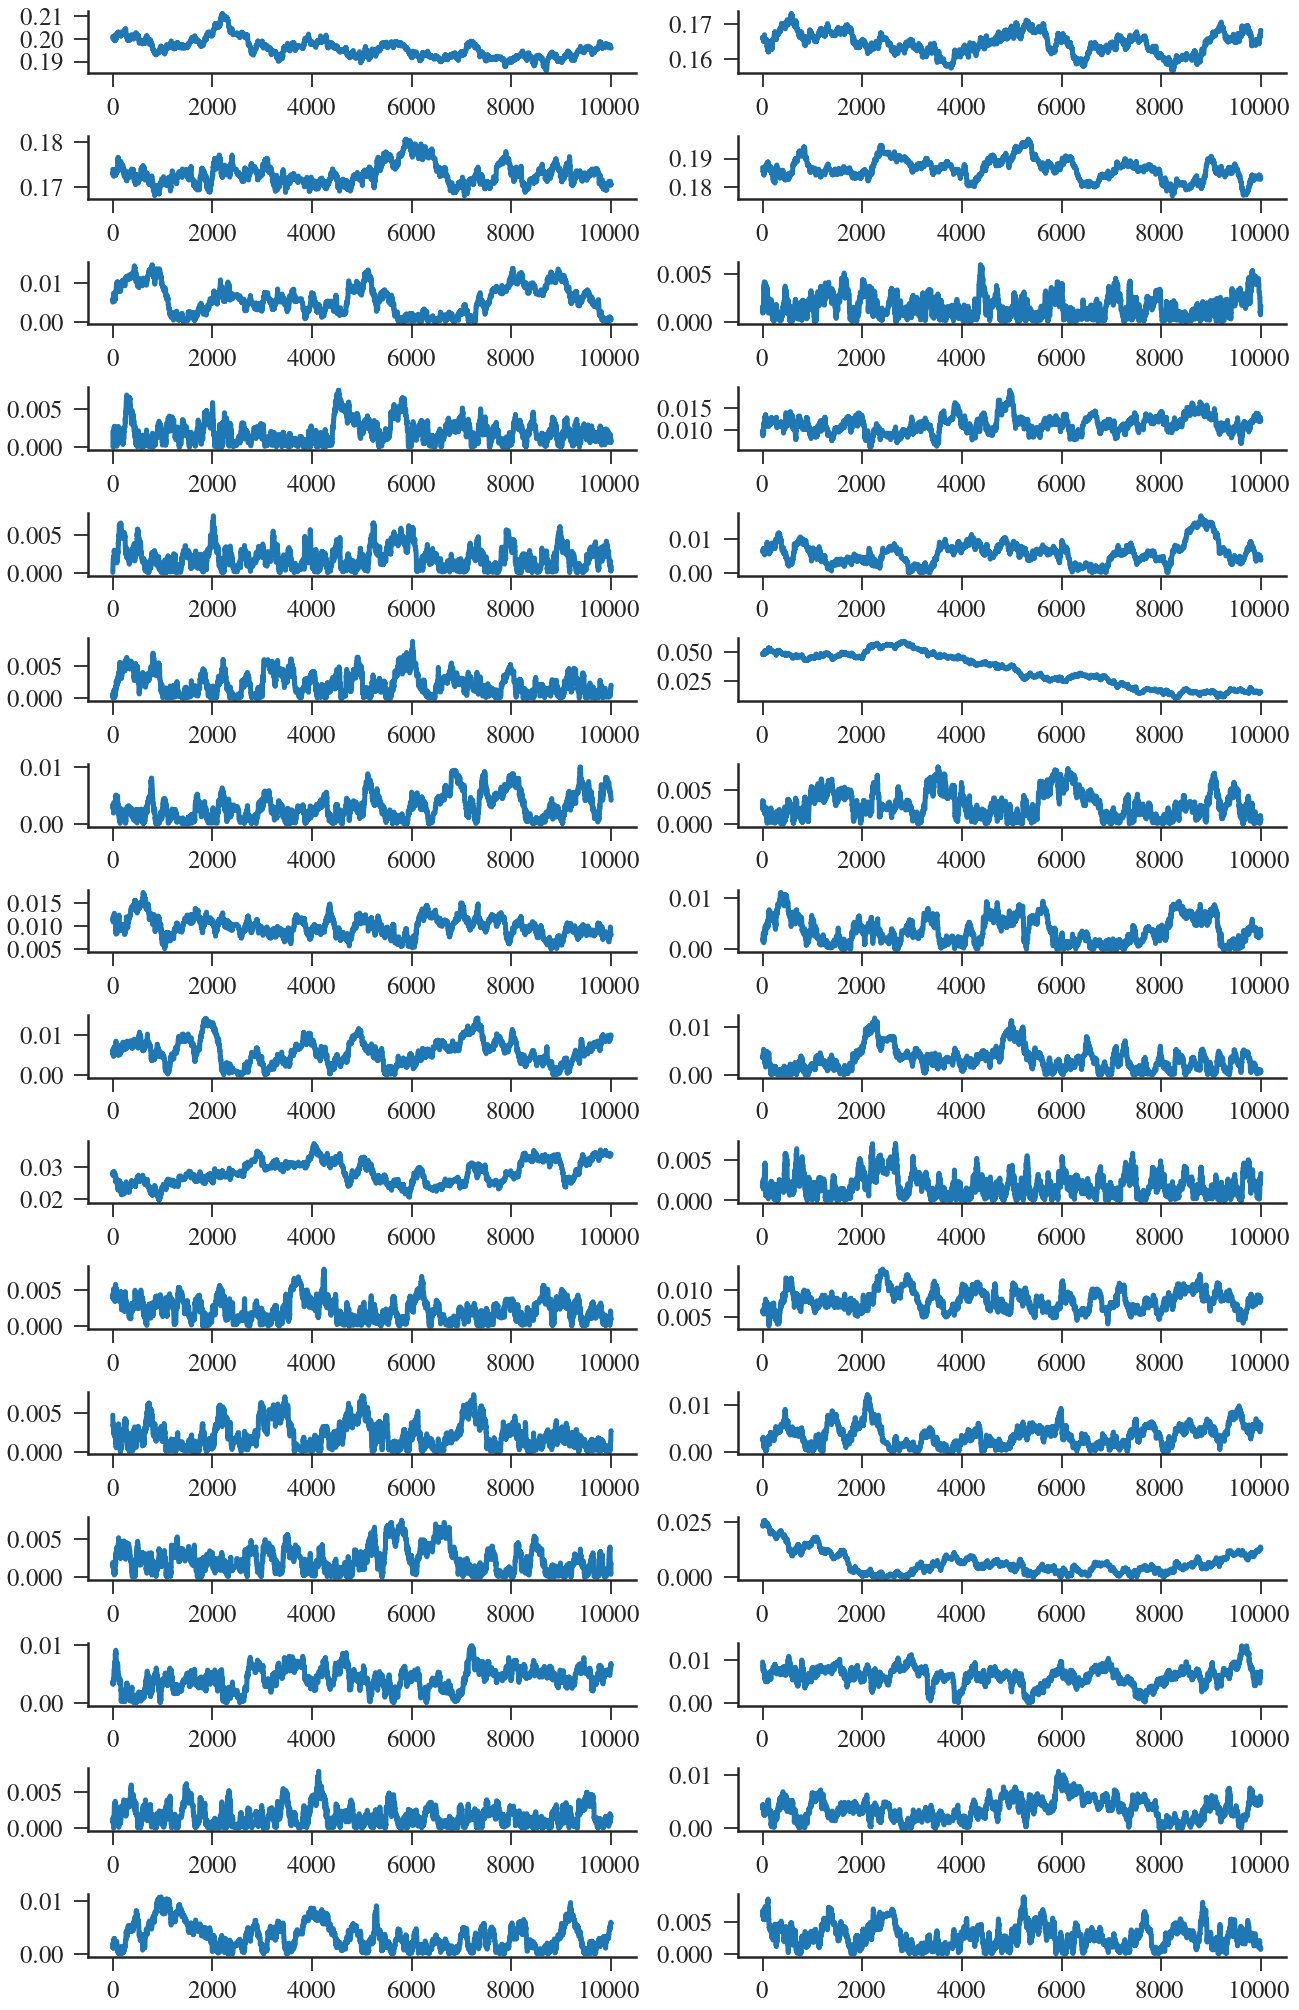

In [630]:
fig, ax = plt.subplots(nrows=16,ncols=2, figsize=stdfigsize(nx=1,ny=2, scale=2))

k=0
for i in range(16):
    for j in range(2):
        ax[i,j].plot(samples[30000:, k])
        k+=1
fig.tight_layout()

In [631]:
HH, QQ, TT = ssm(samples[30000:,:].mean(axis=0))
ll, states = kalman(y.T, TT, QQ, Z, HH)

reg0 = np.array([0, 7, 14, 21])
reg1 = reg0+1
reg2 = reg1+1
reg3 = reg2+1
reg4 = reg3+1
reg5 = reg4+1
reg6 = reg5+1

color = ['#7570B3', '#D95F02','#1B9E77', '#E7298A']
regions=["South", "Northeast", "Midwest", "West"]

No handles with labels found to put in legend.


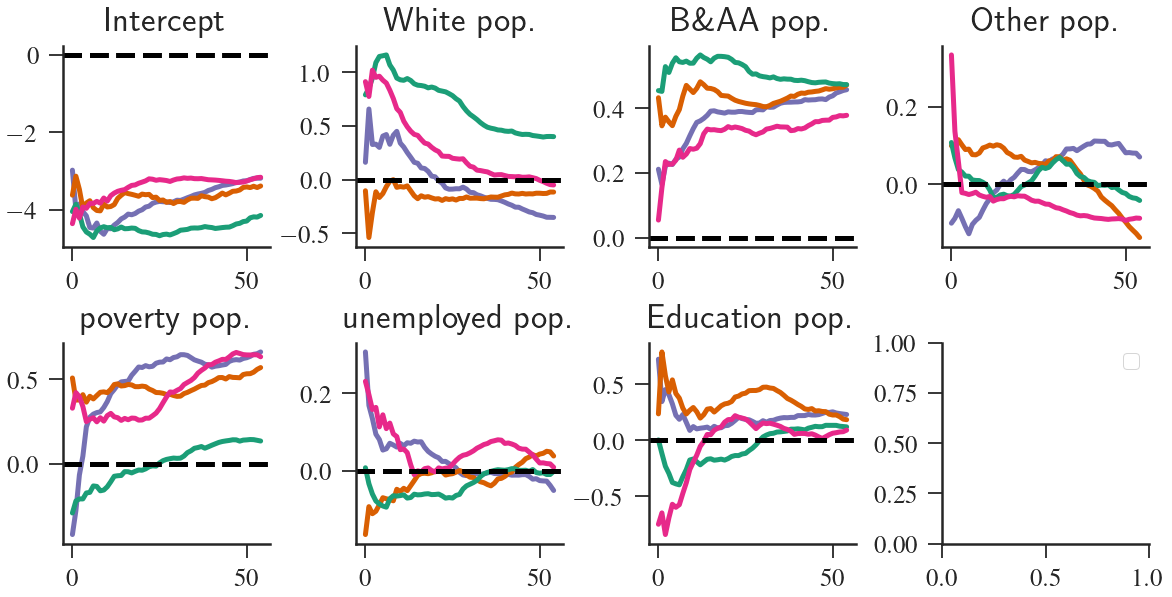

In [632]:
fig, ax = plt.subplots(nrows=2, ncols=4,figsize=stdfigsize(nx=1.5, ny=1., scale=1.2))

k=0
for i in reg0:
    ax[0,0].plot(states[i,:], color=color[k], label=list(regions)[k])
    ax[0,0].axhline(0, linestyle='--', color='k')
    ax[0,0].set_title(r'Intercept')
    
    k+=1
# ax[0,0].legend()

k=0
for i in reg1:
    ax[0,1].plot(states[i,:], color=color[k], label=list(regions)[k])
    ax[0,1].axhline(0, linestyle='--', color='k')
    ax[0,1].set_title(r'White pop.')
    
    k+=1
# ax[0,1].legend()

k=0
for i in reg2:
    ax[0,2].plot(states[i,:], color=color[k],label=list(regions)[k])
    ax[0,2].axhline(0, linestyle='--', color='k')
    ax[0,2].set_title(r'B\&AA pop.')
    
    k+=1
# ax[0,2].legend()

k=0
for i in reg3:
    ax[0,3].plot(states[i,:], color=color[k],label=list(regions)[k])
    ax[0,3].axhline(0, linestyle='--', color='k') 
    ax[0,3].set_title(r'Other pop.')
    
    k+=1
# ax[0,3].legend()

k=0
for i in reg4:
    ax[1,0].plot(states[i,:], color=color[k],label=list(regions)[k])
    ax[1,0].axhline(0, linestyle='--', color='k')  
    ax[1,0].set_title(r'poverty pop.')
    
    k+=1
# ax[1,0].legend()

k=0
for i in reg5:
    ax[1,1].plot(states[i,:], color=color[k],label=list(regions)[k])
    ax[1,1].axhline(0, linestyle='--', color='k')
    ax[1,1].set_title(r'unemployed pop.')
    
    k+=1
# ax[1,1].legend()

k=0
for i in reg6:
    ax[1,2].plot(states[i,:],color=color[k], label=list(regions)[k])
    ax[1,2].axhline(0, linestyle='--', color='k')   
    ax[1,2].set_title(r'Education pop.')
    
    k+=1

    

ax[1,3].legend()
fig.tight_layout()
